In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

from sklearn.impute import KNNImputer


from string import ascii_lowercase
from itertools import combinations
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier
import lightgbm as lgb

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# Q

In [3]:
Answers = []
for i in range(1,27):
    Answers.append('Q'+str(i))
print(Answers)
#Answers = train.iloc[:, 1:27]

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26']


In [4]:
# correlations = train[Answers].corr(method = 'spearman')
# sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

양의 상관관계로 나와서 데이콘에서 바꿔놓은 것으로 간주

*   항목 추가
*   항목 추가


->부호 변경 하지 않음

In [5]:
# 결측치 확인
train[Answers].isnull().sum()

Q1     41
Q2     69
Q3     50
Q4     71
Q5     38
Q6     48
Q7     76
Q8     48
Q9     56
Q10    72
Q11    59
Q12    67
Q13    40
Q14    36
Q15    45
Q16    33
Q17    37
Q18    63
Q19    53
Q20    45
Q21    39
Q22    38
Q23    50
Q24    61
Q25    44
Q26    68
dtype: int64

## 결측치 예측을 위한 두 가지 방법

1. sklearn에서 제공하는 KNNImputer: 

- train 데이터를 채우기 적합.
하지만 test데이터에 사용하기에는 data leakage 문제 발생

2. knn 모델을 만들기: 

- train data의 결측치를 KNNImputer로 채우고
k-nn모델을 만들어서 test data의 결측치를 채우자!
    

In [6]:
# 자주 사용할 것 같으니 사용자 함수를 만들어 볼게요!

def knull(col):
    imputer = KNNImputer(n_neighbors=3)
    a = imputer.fit_transform(train[col])
    train[col] = a

#knull(col) : null값을 knn을 사용하여 채워줍니다.
#여기서 주의 하실점이 있어요. col이 2차원 데이터여야지 knn이 가능합니다. 그래서 Q나 TIPI에만 사용할 수 있어요
# 아니면 결측치를 채우고 싶은 col과 다른 col들을 묶어서 넣어주어도 가능합니다. 물론 이상치 제거가 우선되야겠죠?

In [7]:
knull(Answers) # train의 Answers들의 null값을 채웠습니다!

In [8]:
for i in range(len(Answers)):
    test[Answers[i]]=test[Answers[i]].fillna(train[Answers[i]].mode()[0])

# data leakage 규정을 준수하기 위해 

In [9]:
test[Answers].isnull().sum()

Q1     0
Q2     0
Q3     0
Q4     0
Q5     0
Q6     0
Q7     0
Q8     0
Q9     0
Q10    0
Q11    0
Q12    0
Q13    0
Q14    0
Q15    0
Q16    0
Q17    0
Q18    0
Q19    0
Q20    0
Q21    0
Q22    0
Q23    0
Q24    0
Q25    0
Q26    0
dtype: int64

In [10]:
# # iterativelmputer 함수를 써볼까...? 일단 보류



# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer 

# train_copy = train.copy()
# test_copy = test.copy()

# def null_(df):
#     df = IterativeImputer(random_state=2021).fit_transform(train)
#     df = pd.DataFrame(df)
#     if df.shape[1] == train_copy.shape[1]:
#         df.columns = train_copy.columns
#     else:
#         df.columns = test_copy.columns 
#     return df

# train = null_(train)
# test = null_(test)

In [11]:
# from sklearn.neighbors import KNeighborsClassifier

# classifier = KNeighborsClassifier(n_neighbors = 3)

# classifier.fit(train[Answers])


In [12]:
Q_secret= ['Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26']
           
train['Q_score']= train[Answers].sum(axis=1)
test['Q_score']= test[Answers].sum(axis=1)
train['Qs_score']= train[Q_secret].sum(axis=1)
test['Qs_score']= test[Q_secret].sum(axis=1)


In [13]:
test['Q_score'].isnull().sum()

0

In [14]:
#Tatic/ Morality/ View로 분류하여 새로운 피처 생성
dataset = [train, test]
for data in dataset:
  data['T'] = data['Q1']+data['Q2']+data['Q3']+data['Q7']+data['Q10']+data['Q12']+data['Q15']+data['Q16'] 
  data['V'] = data['Q4']+data['Q5']+data['Q8']+data['Q11']+data['Q13']+data['Q20']
  data['M'] = data['Q9']+data['Q19']

In [15]:
#분산 피처 생성
for data in dataset:
  data['Mach_var'] = data[Answers].var(axis = 1)

In [16]:
#기존 Q drop 
for data in dataset:
  data.drop([('Q'+str(i) )for i in range(1,27)], axis = 1, inplace = True)

## Country

In [17]:
train['country'].value_counts()

USA    7419
GBR    1109
CAN     915
AUS     525
DEU     473
       ... 
PNG       1
MUS       1
MDV       1
GRL       1
ETH       1
Name: country, Length: 137, dtype: int64

In [18]:
len(train['country'].unique())

138

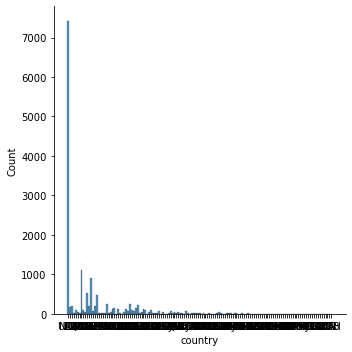

In [19]:
sns.displot(train, x= 'country')

In [20]:
from IPython.display import Image

In [21]:
Image("./country.jpg")
# 사진이 보고싶다면 보내드려요

FileNotFoundError: No such file or directory: './country.jpg'

FileNotFoundError: No such file or directory: './country.jpg'

<IPython.core.display.Image object>

In [22]:
# 자 이제 해봅시다.

pd.get_dummies(train, columns = ['country'])

,index,introelapse,testelapse,surveyelapse,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,...,country_UGA,country_UKR,country_URY,country_USA,country_VEN,country_VGB,country_VIR,country_VNM,country_ZAF,country_ZMB
0,0,3,553,6,4.0,3.0,5.0,1.0,3.0,5.0,...,0,0,0,1,0,0,0,0,0,0
1,1,5,85,120,4.0,2.0,3.0,5.0,3.0,2.0,...,0,0,0,1,0,0,0,0,0,0
2,2,9,108,100,1.0,2.0,3.0,1.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,0
3,3,2,121,139,3.0,3.0,3.0,4.0,5.0,3.0,...,0,0,0,1,0,0,0,0,0,0
4,4,3,640,216,3.0,3.0,4.0,4.0,4.0,4.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,12,103,161,2.0,2.0,4.0,3.0,3.0,5.0,...,0,0,0,1,0,0,0,0,0,0
14996,14996,31,106,179,3.0,2.0,4.0,5.0,4.0,3.0,...,0,0,0,1,0,0,0,0,0,0
14997,14997,17,103,168,1.0,3.0,2.0,5.0,1.0,5.0,...,0,0,0,1,0,0,0,0,0,0
14998,14998,14,68,109,1.0,1.0,3.0,5.0,4.0,5.0,...,0,0,0,1,0,0,0,0,0,0


## 여기서 부터 삽집입니다 보지도 마세요

In [23]:
def country_label(data):
    nara = data['country'].copy()
    nara_val = nara.value_counts()
    
    a = [] 
    b = []
    c = []
    d = []
    e = []
    f = []
    g = []

    
    for i in range(len(nara_val)):
        if nara_val.values[i] <= 10 : a.append(nara_val.index[i])
        elif 50>nara_val.values[i] >=10 : b.append(nara_val.index[i])
        elif 100>nara_val.values[i] >= 50 :c.append(nara_val.index[i])
        elif 200>nara_val.values[i] >= 100 : d.append(nara_val.index[i])
        elif 500>=nara_val.values[i] >= 200 :  e.append(nara_val.index[i])
        elif 5000> nara_val.values[i] > 500 : f.append(nara_val.index[i])
        elif nara_val.values[i]  > 5000 : g.append(nara_val.index[i])


    for i in range(len(nara)):
        if nara[i] in a: nara[i]=0
        if nara[i] in b: nara[i]=1
        if nara[i] in c: nara[i]=2
        if nara[i] in d: nara[i]=3
        if nara[i] in e: nara[i]=4
        if nara[i] in f: nara[i]=5
        if nara[i] in g: nara[i]=6
        
    nara.fillna(0, inplace = True)
    return nara

In [24]:

nara_train = country_label(train)
nara_test = country_label(test)
train['nara'] = nara_train
test['nara'] = nara_test

train = train.drop(columns=['country'], axis = 1)
test = test.drop(columns=['country'], axis = 1)


## 여기까지 삽질이었습니다. 이제 보세요

# TIPI

In [25]:
TIPI = []
for i in range(1,11):
    TIPI.append('TIPI'+str(i))

# TIPI_correlations = train[TIPI].corr(method = 'spearman')
# sns.heatmap(TIPI_correlations, cmap="coolwarm", square=True, center=0)

In [26]:
knull(TIPI) # 결측치 제거

In [27]:
for i in range(len(TIPI)):
    test[TIPI[i]]=test[TIPI[i]].fillna(train[TIPI[i]].mode()[0])

# data leakage 규정을 준수하기 위해 

In [28]:
train['Extraverted'] = train['TIPI1'] - train['TIPI6']
train['Warm'] = train['TIPI7']-train['TIPI2']
train['Dependable'] = train['TIPI3']-train['TIPI8']
train['Calm'] = train['TIPI9']-train['TIPI4']
train['OpenMind'] = train['TIPI5']-train['TIPI10']

test['Extraverted'] = test['TIPI1'] - test['TIPI6']
test['Warm'] = test['TIPI7']-test['TIPI2']
test['Dependable'] = test['TIPI3']-test['TIPI8']
test['Calm'] = test['TIPI9']-test['TIPI4']
test['OpenMind'] = test['TIPI5']-test['TIPI10']

In [29]:
# #비율 만들었으니 기존 TIPI drop
train.drop([('TIPI'+str(i)) for i in range(1,10)], axis=1, inplace = True)
train.drop('TIPI10', axis = 1, inplace = True)


test.drop([('TIPI'+str(i)) for i in range(1,10)], axis=1, inplace = True)
test.drop('TIPI10', axis = 1, inplace = True)


# VCL

In [30]:
VCL = []
for i in range(1,17):
    VCL.append('VCL'+str(i))
print(VCL)

['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16']


In [31]:
# 실제로 있고 진짜 쉬운단어 (작성자의 영어 실력을 알 수 있습니다.)
VCL_1 = ['VCL1','VCL4','VCL5','VCL10','VCL14','VCL16']
# 실제로 있는데 어려운 단어
VCL_2 = ['VCL2','VCL3','VCL7','VCL8','VCL11','VCL13','VCL14']
# 세상에 없는 단어
VCL_3 = ['VCL6','VCL9','VCL12'] # 0 ~ 3 이 나올텐데 3에 가까울 수록 nerdiness일 확률 높다?

In [32]:
dataset = [train,test]
for data in dataset:
    data['VCL_score'] = data[VCL].sum(axis=1)
    data['VCL_1_score'] = data[VCL_1].sum(axis=1)
    data['VCL_2_score'] = data[VCL_2].sum(axis=1)
    data['VCL_3_score'] = data[VCL_3].sum(axis=1)
    data.drop([('VCL'+str(i) )for i in range(1,17)], axis = 1, inplace = True)


# Hand

In [33]:
train.drop('hand', axis=1, inplace = True)
test.drop('hand', axis=1, inplace = True)


# family size

In [34]:
#이상치 제거
train = train.drop(train[train.familysize > 50].index)
test = test.drop(test[test.familysize > 50].index)

# religion & married & voted & orientation

In [35]:
train[['familysize','religion','orientation', 'married','voted']].isnull().sum()

familysize     319
religion       245
orientation    399
married         82
voted           85
dtype: int64

In [36]:
knull(['familysize','religion','orientation','married','voted','nerdiness'])

In [37]:
train[['familysize','religion','orientation', 'married','voted']].isnull().sum()

familysize     0
religion       0
orientation    0
married        0
voted          0
dtype: int64

In [38]:
train.columns

Index(['index', 'introelapse', 'testelapse', 'surveyelapse', 'education',
       'urban', 'gender', 'engnat', 'age', 'religion', 'orientation', 'voted',
       'married', 'familysize', 'ASD', 'nerdiness', 'Q_score', 'Qs_score', 'T',
       'V', 'M', 'Mach_var', 'nara', 'Extraverted', 'Warm', 'Dependable',
       'Calm', 'OpenMind', 'VCL_score', 'VCL_1_score', 'VCL_2_score',
       'VCL_3_score'],
      dtype='object')

# Age


In [39]:
# plt.figure(figsize = (8,6))
# sns.countplot(data=train, x='age', hue = train['nerdiness'])

In [40]:
age_counts = train['age'].value_counts()
for idx, (val, cnt) in enumerate(age_counts.iteritems(), 1):
    print("Top", idx, ";", val, cnt)

Top 1 ; 18 1386
Top 2 ; 17 1313
Top 3 ; 16 1239
Top 4 ; 19 1101
Top 5 ; 20 932
Top 6 ; 15 899
Top 7 ; 21 833
Top 8 ; 22 663
Top 9 ; 23 605
Top 10 ; 14 533
Top 11 ; 25 478
Top 12 ; 24 437
Top 13 ; 13 353
Top 14 ; 26 349
Top 15 ; 27 325
Top 16 ; 28 306
Top 17 ; 30 236
Top 18 ; 29 233
Top 19 ; 32 186
Top 20 ; 31 177
Top 21 ; 33 161
Top 22 ; 34 153
Top 23 ; 35 142
Top 24 ; 36 141
Top 25 ; 37 121
Top 26 ; 40 110
Top 27 ; 38 101
Top 28 ; 45 99
Top 29 ; 42 96
Top 30 ; 44 83
Top 31 ; 41 80
Top 32 ; 43 77
Top 33 ; 39 75
Top 34 ; 47 75
Top 35 ; 50 73
Top 36 ; 48 69
Top 37 ; 46 69
Top 38 ; 49 64
Top 39 ; 51 58
Top 40 ; 55 57
Top 41 ; 54 47
Top 42 ; 60 46
Top 43 ; 52 45
Top 44 ; 58 43
Top 45 ; 53 37
Top 46 ; 59 33
Top 47 ; 57 33
Top 48 ; 56 33
Top 49 ; 64 29
Top 50 ; 62 22
Top 51 ; 65 21
Top 52 ; 61 20
Top 53 ; 63 19
Top 54 ; 67 15
Top 55 ; 68 12
Top 56 ; 66 10
Top 57 ; 69 8
Top 58 ; 72 6
Top 59 ; 71 5
Top 60 ; 73 3
Top 61 ; 75 3
Top 62 ; 74 3
Top 63 ; 78 3
Top 64 ; 76 2
Top 65 ; 70 2
Top 66 ; 123

In [41]:
#이상치 제거
train = train.drop(train[train.age > 100].index)
test = test.drop(test[test.age > 100].index)

In [42]:
np.log1p(train['age'])

0        3.044522
1        3.912023
2        3.784190
3        2.890372
4        2.944439
           ...   
14995    2.890372
14996    3.828641
14997    3.044522
14998    3.401197
14999    3.091042
Name: age, Length: 14993, dtype: float64

In [43]:
bins = [0, 10, 20, 30,40,50, 60,70,80,90,100]
label = [0,1,2,3,4,5,6,7,8,9]
train['age_cuts'] = pd.cut(train['age'], bins, right=True, labels=label)

<AxesSubplot:xlabel='age_cuts', ylabel='count'>

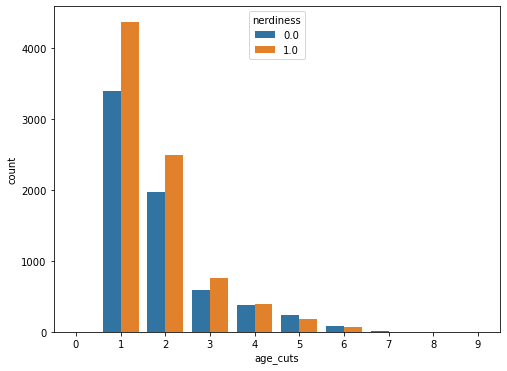

In [44]:
plt.figure(figsize = (8,6))
sns.countplot(data=train, x='age_cuts', hue = train['nerdiness'])

In [45]:
train

,index,introelapse,testelapse,surveyelapse,education,urban,gender,engnat,age,religion,...,Extraverted,Warm,Dependable,Calm,OpenMind,VCL_score,VCL_1_score,VCL_2_score,VCL_3_score,age_cuts
0,0,3,553,6,2.0,1,3.0,1.0,20,12.0,...,-1.0,2.0,2.0,4.0,0.0,8,6,2,0,1
1,1,5,85,120,4.0,2,2.0,1.0,49,2.0,...,2.0,3.0,2.0,-3.0,1.0,11,6,5,0,4
2,2,9,108,100,2.0,1,1.0,2.0,43,2.0,...,-4.0,1.0,-1.0,4.0,3.0,11,6,5,0,4
3,3,2,121,139,1.0,3,1.0,1.0,17,1.0,...,0.0,1.0,-1.0,-1.0,2.0,9,6,3,0,1
4,4,3,640,216,1.0,2,2.0,2.0,18,12.0,...,-1.0,0.0,0.0,-1.0,2.0,8,6,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,12,103,161,2.0,2,2.0,1.0,17,1.0,...,-3.0,1.0,1.0,0.0,0.0,11,6,4,1,1
14996,14996,31,106,179,4.0,1,2.0,2.0,45,3.0,...,0.0,2.0,3.0,-3.0,2.0,8,6,2,0,4
14997,14997,17,103,168,2.0,2,2.0,1.0,20,1.0,...,-4.0,0.0,-1.0,-4.0,0.0,9,6,3,0,1
14998,14998,14,68,109,3.0,2,2.0,1.0,29,12.0,...,-4.0,4.0,-1.0,-3.0,3.0,12,6,5,1,2


In [46]:
pd.get_dummies(train, columns = ['age_cuts'])

,index,introelapse,testelapse,surveyelapse,education,urban,gender,engnat,age,religion,...,age_cuts_0,age_cuts_1,age_cuts_2,age_cuts_3,age_cuts_4,age_cuts_5,age_cuts_6,age_cuts_7,age_cuts_8,age_cuts_9
0,0,3,553,6,2.0,1,3.0,1.0,20,12.0,...,0,1,0,0,0,0,0,0,0,0
1,1,5,85,120,4.0,2,2.0,1.0,49,2.0,...,0,0,0,0,1,0,0,0,0,0
2,2,9,108,100,2.0,1,1.0,2.0,43,2.0,...,0,0,0,0,1,0,0,0,0,0
3,3,2,121,139,1.0,3,1.0,1.0,17,1.0,...,0,1,0,0,0,0,0,0,0,0
4,4,3,640,216,1.0,2,2.0,2.0,18,12.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,12,103,161,2.0,2,2.0,1.0,17,1.0,...,0,1,0,0,0,0,0,0,0,0
14996,14996,31,106,179,4.0,1,2.0,2.0,45,3.0,...,0,0,0,0,1,0,0,0,0,0
14997,14997,17,103,168,2.0,2,2.0,1.0,20,1.0,...,0,1,0,0,0,0,0,0,0,0
14998,14998,14,68,109,3.0,2,2.0,1.0,29,12.0,...,0,0,1,0,0,0,0,0,0,0


In [47]:
train

,index,introelapse,testelapse,surveyelapse,education,urban,gender,engnat,age,religion,...,Extraverted,Warm,Dependable,Calm,OpenMind,VCL_score,VCL_1_score,VCL_2_score,VCL_3_score,age_cuts
0,0,3,553,6,2.0,1,3.0,1.0,20,12.0,...,-1.0,2.0,2.0,4.0,0.0,8,6,2,0,1
1,1,5,85,120,4.0,2,2.0,1.0,49,2.0,...,2.0,3.0,2.0,-3.0,1.0,11,6,5,0,4
2,2,9,108,100,2.0,1,1.0,2.0,43,2.0,...,-4.0,1.0,-1.0,4.0,3.0,11,6,5,0,4
3,3,2,121,139,1.0,3,1.0,1.0,17,1.0,...,0.0,1.0,-1.0,-1.0,2.0,9,6,3,0,1
4,4,3,640,216,1.0,2,2.0,2.0,18,12.0,...,-1.0,0.0,0.0,-1.0,2.0,8,6,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,12,103,161,2.0,2,2.0,1.0,17,1.0,...,-3.0,1.0,1.0,0.0,0.0,11,6,4,1,1
14996,14996,31,106,179,4.0,1,2.0,2.0,45,3.0,...,0.0,2.0,3.0,-3.0,2.0,8,6,2,0,4
14997,14997,17,103,168,2.0,2,2.0,1.0,20,1.0,...,-4.0,0.0,-1.0,-4.0,0.0,9,6,3,0,1
14998,14998,14,68,109,3.0,2,2.0,1.0,29,12.0,...,-4.0,4.0,-1.0,-3.0,3.0,12,6,5,1,2


In [48]:
train['age_cuts']

0        1
1        4
2        4
3        1
4        1
        ..
14995    1
14996    4
14997    1
14998    2
14999    2
Name: age_cuts, Length: 14993, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [49]:
pd.get_dummies(train['age_cuts'])

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
14995,0,1,0,0,0,0,0,0,0,0
14996,0,0,0,0,1,0,0,0,0,0
14997,0,1,0,0,0,0,0,0,0,0
14998,0,0,1,0,0,0,0,0,0,0


In [50]:
#원핫인코딩

pd.get_dummies(train['age_cuts'])

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
14995,0,1,0,0,0,0,0,0,0,0
14996,0,0,0,0,1,0,0,0,0,0
14997,0,1,0,0,0,0,0,0,0,0
14998,0,0,1,0,0,0,0,0,0,0


In [51]:
train.drop('age', axis=1, inplace = True)
test.drop('age', axis=1, inplace = True)

# Elapse

In [52]:
elapse = ['introelapse', 'testelapse', 'surveyelapse']

In [53]:
# plt.figure(figsize=(8,6))
# sns.countplot(data=train, x='introelapse', hue = train['nerdiness'])

In [54]:
# sns.distplot(train['introelapse'], rug=True)

In [55]:
train[elapse]

,introelapse,testelapse,surveyelapse
0,3,553,6
1,5,85,120
2,9,108,100
3,2,121,139
4,3,640,216
...,...,...,...
14995,12,103,161
14996,31,106,179
14997,17,103,168
14998,14,68,109


In [56]:
np.log1p(train[elapse])


,introelapse,testelapse,surveyelapse
0,1.386294,6.317165,1.945910
1,1.791759,4.454347,4.795791
2,2.302585,4.691348,4.615121
3,1.098612,4.804021,4.941642
4,1.386294,6.463029,5.379897
...,...,...,...
14995,2.564949,4.644391,5.087596
14996,3.465736,4.672829,5.192957
14997,2.890372,4.644391,5.129899
14998,2.708050,4.234107,4.700480


In [57]:
np.log1p(train[elapse])

,introelapse,testelapse,surveyelapse
0,1.386294,6.317165,1.945910
1,1.791759,4.454347,4.795791
2,2.302585,4.691348,4.615121
3,1.098612,4.804021,4.941642
4,1.386294,6.463029,5.379897
...,...,...,...
14995,2.564949,4.644391,5.087596
14996,3.465736,4.672829,5.192957
14997,2.890372,4.644391,5.129899
14998,2.708050,4.234107,4.700480


In [58]:
train[elapse]=np.log1p(train[elapse])

In [59]:
def get_outlier(df=None, column=None, weight=1.5): 
    data = df[column]
    quantile_25 = np.percentile(data.values, 25)
    print("25:",quantile_25 )
    quantile_75 = np.percentile(data.values, 75)
    print("75", quantile_75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    lowest_val = quantile_25 - iqr_weight
    print("lowest:",lowest_val )
    highest_val = quantile_75+iqr_weight
    print("highest_val:",highest_val )
    outlier_index= data[(data<lowest_val)|(data>highest_val)].index
    return outlier_index

In [60]:
train['surveyelapse'].sort_values(ascending = False).tail(20) #로그스케일링 후 이상치가 특이하게 튀는거 같지는 않아서 이상치를 굳이 제거하거나 대체?할 필요가 있을까 싶음


6811     2.302585
12311    2.302585
14897    2.197225
12059    2.197225
9736     2.197225
14765    1.945910
5467     1.945910
0        1.945910
12756    1.945910
11990    1.945910
4766     1.791759
1775     1.791759
13237    1.791759
3176     1.791759
6575     1.791759
663      1.609438
738      1.609438
835      1.609438
14037    1.609438
9142     1.386294
Name: surveyelapse, dtype: float64

In [61]:
#걸린시간 합
train['elapse_sum'] = train['testelapse']+train['surveyelapse']
test['elapse_sum'] = test['testelapse']+test['surveyelapse']

In [62]:
#비율 
train['test_dv_survey']=train['testelapse']/train['surveyelapse'] 
test['test_dv_survey']=test['testelapse']/test['surveyelapse'] 

In [63]:
train['ASD'] = train['ASD'].fillna(train['ASD'].mode()[0])
test['ASD'] = test['ASD'].fillna(test['ASD'].mode()[0])

In [64]:
train['education'] = train['education'].fillna(train['education'].mode()[0])
test['education'] = test['education'].fillna(train['education'].mode()[0])

In [65]:
train['engnat'] = train['engnat'].fillna(train['engnat'].mode()[0])
test['engnat'] = test['engnat'].fillna(train['engnat'].mode()[0])

In [66]:
train['gender'] = train['gender'].fillna(train['gender'].mode()[0])
test['gender'] = test['gender'].fillna(train['gender'].mode()[0])

In [67]:
test['religion'] = test['religion'].fillna(train['religion'].mode()[0])
test['orientation'] = test['orientation'].fillna(train['orientation'].mode()[0])
test['voted'] = test['voted'].fillna(train['voted'].mode()[0])
test['married'] = test['married'].fillna(train['married'].mode()[0])
test['familysize'] = test['familysize'].fillna(train['familysize'].mode()[0])


In [68]:
train.drop('nara', axis=1, inplace = True)
test.drop('nara', axis=1, inplace = True)



In [69]:
train.drop('index', axis=1, inplace = True)
test.drop('index', axis=1, inplace = True)



In [70]:
# feature 수 맞춰주려고 잠깐만 지울게요
train.drop('age_cuts', axis=1, inplace = True)


In [71]:
train.columns

Index(['introelapse', 'testelapse', 'surveyelapse', 'education', 'urban',
       'gender', 'engnat', 'religion', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'nerdiness', 'Q_score', 'Qs_score', 'T', 'V', 'M',
       'Mach_var', 'Extraverted', 'Warm', 'Dependable', 'Calm', 'OpenMind',
       'VCL_score', 'VCL_1_score', 'VCL_2_score', 'VCL_3_score', 'elapse_sum',
       'test_dv_survey'],
      dtype='object')

In [72]:
test.columns

Index(['introelapse', 'testelapse', 'surveyelapse', 'education', 'urban',
       'gender', 'engnat', 'religion', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'Q_score', 'Qs_score', 'T', 'V', 'M', 'Mach_var',
       'Extraverted', 'Warm', 'Dependable', 'Calm', 'OpenMind', 'VCL_score',
       'VCL_1_score', 'VCL_2_score', 'VCL_3_score', 'elapse_sum',
       'test_dv_survey'],
      dtype='object')

In [73]:
x_train = train.copy()
x_train.drop('nerdiness', axis=1, inplace = True)
y_train = train['nerdiness']


In [74]:
len(train.columns)

31

In [80]:
train

,introelapse,testelapse,surveyelapse,education,urban,gender,engnat,religion,orientation,voted,...,Warm,Dependable,Calm,OpenMind,VCL_score,VCL_1_score,VCL_2_score,VCL_3_score,elapse_sum,test_dv_survey
0,1.386294,6.317165,1.945910,2.0,1,3.0,1.0,12.0,4.0,2.0,...,2.0,2.0,4.0,0.0,8,6,2,0,8.263075,3.246380
1,1.791759,4.454347,4.795791,4.0,2,2.0,1.0,2.0,1.0,1.0,...,3.0,2.0,-3.0,1.0,11,6,5,0,9.250138,0.928804
2,2.302585,4.691348,4.615121,2.0,1,1.0,2.0,2.0,2.0,2.0,...,1.0,-1.0,4.0,3.0,11,6,5,0,9.306468,1.016517
3,1.098612,4.804021,4.941642,1.0,3,1.0,1.0,1.0,1.0,2.0,...,1.0,-1.0,-1.0,2.0,9,6,3,0,9.745663,0.972151
4,1.386294,6.463029,5.379897,1.0,2,2.0,2.0,12.0,1.0,2.0,...,0.0,0.0,-1.0,2.0,8,6,3,0,11.842927,1.201330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.564949,4.644391,5.087596,2.0,2,2.0,1.0,1.0,3.0,2.0,...,1.0,1.0,0.0,0.0,11,6,4,1,9.731987,0.912885
14996,3.465736,4.672829,5.192957,4.0,1,2.0,2.0,3.0,1.0,1.0,...,2.0,3.0,-3.0,2.0,8,6,2,0,9.865786,0.899840
14997,2.890372,4.644391,5.129899,2.0,2,2.0,1.0,1.0,2.0,1.0,...,0.0,-1.0,-4.0,0.0,9,6,3,0,9.774290,0.905357
14998,2.708050,4.234107,4.700480,3.0,2,2.0,1.0,12.0,4.0,2.0,...,4.0,-1.0,-3.0,3.0,12,6,5,1,8.934587,0.900782


In [75]:
k_fold = KFold(n_splits = 3, shuffle = True, random_state = 0)

In [82]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [81]:
for train_f, val_f in k_fold.split(train):
    
    clf1 = RandomForestClassifier(n_estimators=500)
    clf2 = LGBMClassifier()
    clf3 = GradientBoostingClassifier()
    soft_vote  = VotingClassifier([('r1',clf1), ('r2', clf2), ('r3',clf3)], voting='soft')
    soft_vote.fit(train_f, val_f)
    
    model = soft_vote
    pred_f = model.predict_proba(val_f)
    pred_f = pred_f[:,1]
    
    print(accuracy_score(val_f, pred_f))
    print(recall_score(val_f, pred_f))
    print(precision_score(val_f, pred_f))
    print(f1_score(val_f, pred_f))


ValueError: Expected 2D array, got 1D array instead:
array=[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.4989e+04 1.4990e+04 1.4991e+04].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [76]:
clf1 = RandomForestClassifier(n_estimators=500)
clf2 = LGBMClassifier()
clf3 = GradientBoostingClassifier()
soft_vote  = VotingClassifier([('r1',clf1), ('r2', clf2), ('r3',clf3)], voting='soft')
soft_vote.fit(x_train, y_train)


VotingClassifier(estimators=[('r1', RandomForestClassifier(n_estimators=500)),
                             ('r2', LGBMClassifier()),
                             ('r3', GradientBoostingClassifier())],
                 voting='soft')

In [77]:
model = soft_vote
pred_y = model.predict_proba(test)
pred_y = pred_y[:,1]


In [78]:
pred = soft_vote.predict(test)

In [79]:
submission = pd.DataFrame({
    "nerdiness" : pred_y
})
submission.to_csv('sub_0817_1.csv', index=True)

In [ ]:
model3 = LGBMClassifier(objective="binary", num_iterations= 10**3)

x_train_3 = x_train[lgbm_archive_3.iloc[7,2]]

model3.fit(x_train_3, y_train)

pred_y3 = model3.predict_proba(test[lgbm_archive_3.iloc[7,2]])
pred_y3 = pred_y3[:,1]